In [1]:
# %load_ext autoreload
# %autoreload 2

import os
import sys

import torch
from torch.optim import SGD
from torch import nn

## Access src directory from ./notebooks/ folder
from pathlib import Path
sys.path.append(str(Path('.').absolute().parent))

from src.Snip import SNIP
from src.models import *
from src.optimization import epoch

import numpy as np
import matplotlib.pyplot as plt

In [2]:
import torchvision
from torchvision.datasets import CIFAR10
import torchvision.transforms as transforms

In [8]:
# Data
print('==> Preparing data..')
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
train_data_loader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
test_data_loader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False, num_workers=2)

==> Preparing data..
Files already downloaded and verified
Files already downloaded and verified


In [9]:
def train_model(model, snip = None, epochs = 20):

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters())

    model = model.cuda()
    criterion = criterion.cuda()
    
    if snip:
        hooks = snip.register_masks()
        assert snip.K == snip.get_nonzero_param_number()

    train_losses = []
    test_losses = []
    accuracys = []
    # On itère sur les epochs
    for i in range(epochs):
        print("=================\n=== EPOCH "+str(i+1)+" =====\n=================\n")
        # Phase de train
        _, loss = epoch(train_data_loader, model, criterion,snip_pruning=snip, optimizer=optimizer)
        # Phase d'evaluation
        with torch.no_grad():
            acc_test, loss_test = epoch(test_data_loader, model, criterion)

        train_losses.append(loss.avg)
        test_losses.append(loss_test.avg)
        accuracys.append(acc_test.avg)

    if snip:
        for hook in hooks:
            hook.remove()
        nonzero_params = snip.get_nonzero_param_number()
        print(nonzero_params)
        assert snip.K == nonzero_params

    return train_losses, test_losses, accuracys

def print_losses_and_acc(training_losses_, test_losses_, acc_):
    plt.title("L'erreur moyenne d'un patch dans generation des noms")
    plt.plot(np.arange(len(training_losses_)), training_losses_, label="Train")
    plt.plot(np.arange(len(test_losses_)), test_losses_, label="Test")
    plt.ylabel("L'erreur")
    plt.xlabel('Epochs')
    plt.legend()
    plt.figure()
    plt.plot(np.arange(len(acc_)), acc_)
    plt.show()

In [10]:
original_model = AlexNet()
train_losses, test_losses, accuracys  = train_model(original_model)

=== EPOCH 1 =====

[TRAIN Batch 000/391]	Time 0.163s (0.163s)	Loss 2.3034 (2.3034)	Prec   0.1 (  0.1)

[TRAIN Batch 100/391]	Time 0.058s (0.060s)	Loss 1.8852 (2.0915)	Prec   0.3 (  0.2)

[TRAIN Batch 200/391]	Time 0.059s (0.059s)	Loss 1.7012 (1.9426)	Prec   0.3 (  0.2)

[TRAIN Batch 300/391]	Time 0.059s (0.059s)	Loss 1.4926 (1.8430)	Prec   0.4 (  0.3)


===============> Total time 23s	Avg loss 1.7814	Avg Prec  0.32 %

[EVAL Batch 000/100]	Time 0.149s (0.149s)	Loss 1.5809 (1.5809)	Prec   0.4 (  0.4)


===============> Total time 1s	Avg loss 1.5459	Avg Prec  0.43 %

=== EPOCH 2 =====

[TRAIN Batch 000/391]	Time 0.215s (0.215s)	Loss 1.6521 (1.6521)	Prec   0.4 (  0.4)

[TRAIN Batch 100/391]	Time 0.058s (0.061s)	Loss 1.3698 (1.5138)	Prec   0.5 (  0.4)

[TRAIN Batch 200/391]	Time 0.059s (0.060s)	Loss 1.3605 (1.4857)	Prec   0.6 (  0.5)

[TRAIN Batch 300/391]	Time 0.058s (0.060s)	Loss 1.3388 (1.4611)	Prec   0.5 (  0.5)


===============> Total time 23s	Avg loss 1.4405	Avg Prec  0.47 %

[EVAL B

[TRAIN Batch 300/391]	Time 0.059s (0.059s)	Loss 0.8243 (0.8325)	Prec   0.7 (  0.7)


===============> Total time 23s	Avg loss 0.8335	Avg Prec  0.71 %

[EVAL Batch 000/100]	Time 0.091s (0.091s)	Loss 0.7292 (0.7292)	Prec   0.8 (  0.8)


===============> Total time 1s	Avg loss 0.8210	Avg Prec  0.71 %

=== EPOCH 15 =====

[TRAIN Batch 000/391]	Time 0.149s (0.149s)	Loss 0.8919 (0.8919)	Prec   0.7 (  0.7)

[TRAIN Batch 100/391]	Time 0.059s (0.060s)	Loss 0.7234 (0.8105)	Prec   0.8 (  0.7)

[TRAIN Batch 200/391]	Time 0.066s (0.060s)	Loss 0.7326 (0.8047)	Prec   0.8 (  0.7)

[TRAIN Batch 300/391]	Time 0.064s (0.060s)	Loss 0.9360 (0.8072)	Prec   0.7 (  0.7)


===============> Total time 23s	Avg loss 0.8103	Avg Prec  0.72 %

[EVAL Batch 000/100]	Time 0.143s (0.143s)	Loss 0.7313 (0.7313)	Prec   0.7 (  0.7)


===============> Total time 1s	Avg loss 0.7858	Avg Prec  0.73 %

=== EPOCH 16 =====

[TRAIN Batch 000/391]	Time 0.232s (0.232s)	Loss 0.6586 (0.6586)	Prec   0.8 (  0.8)

[TRAIN Batch 100/391]	Ti

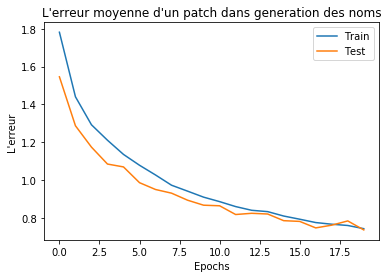

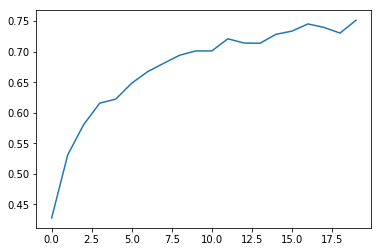

In [11]:
print_losses_and_acc(train_losses, test_losses, accuracys)

In [ ]:
prune_model = AlexNet()
snip = SNIP(prune_model)
total_param_number = snip.get_total_param_number()
print("Original number of params : {}".format(total_param_number))
K = total_param_number // 10
print("10% of params : {}".format(K))
C_masks = snip.compute_mask(train_data_loader, K=K)

train_losses, test_losses, accuracys  = train_model(prune_model, snip);

Original number of params : 23272266
10% of params : 2327226
